In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets

# Original training data directory with class subfolders
original_data_dir = "/content/drive/My Drive/CAM16_100cls_10mask/train/data"

# Directory to store augmented images with class subfolders
augmented_data_dir = "/content/drive/My Drive/CAM16_augmented"

# Create class subfolders in the augmented data directory
class_names = os.listdir(original_data_dir)
for class_name in class_names:
    class_dir = os.path.join(augmented_data_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

# Define data transformations for data augmentation
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),  # You can adjust the degree of rotation
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),  # Resize and crop
    transforms.ToTensor(),
])

# Load the original training dataset with class subfolders
train_data = datasets.ImageFolder(original_data_dir, transform=data_transforms)

# Apply data augmentation and save augmented images with class subfolders
for i, (image, label) in enumerate(train_data):
    class_name = class_names[label]
    class_dir = os.path.join(augmented_data_dir, class_name)

    # Save the augmented image with a new file name
    augmented_image_path = os.path.join(class_dir, f"augmented_{i}.jpg")
    torchvision.utils.save_image(image, augmented_image_path)

print("Data augmentation complete.")


In [ ]:
import shutil
import os

source_folder = "/content/drive/My Drive/CAM16_augmented/tumor"

destination_folder = "/content/drive/My Drive/CAM16_100cls_10mask/train/data/tumor"

os.makedirs(destination_folder, exist_ok=True)

image_files = [f for f in os.listdir(source_folder) if f.endswith(('.jpg', '.png'))]

# Copy each image file to the destination folder
for image_file in image_files:
    source_path = os.path.join(source_folder, image_file)
    destination_path = os.path.join(destination_folder, image_file)

    # Use shutil.copy to copy the file
    shutil.copy(source_path, destination_path)

print("Images copied successfully.")


Images copied successfully.


**Loading the data**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define the paths to your dataset directories
train_dir = "/content/drive/My Drive/CAM16_100cls_10mask/train/data"
val_dir = "/content/drive/My Drive/CAM16_100cls_10mask/val/data"
test_dir = "/content/drive/My Drive/CAM16_100cls_10mask/test/data"

# Image dimensions
img_width, img_height = 384, 384

# Define label mappings
label_mapping = {
    'normal': 0,
    'tumor': 1
}

# Define data transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

# Load data from the 'train' directory
train_data = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Load data from the 'val' directory
val_data = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_data, batch_size=32)

# Load data from the 'test' directory
test_data = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_data, batch_size=32)

input_size = 64 * ((img_height // 4 - 1) * (img_width // 4 - 1))





In [ ]:
num_images_in_train_loader = len(train_loader.dataset)
print(f"Number of images in train loader: {num_images_in_train_loader}")

Number of images in train loader: 1588


**Defining the cam-16 class**

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 48 * 48, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize the model
model = CNNModel()

# Move the model to the GPU
model = model.to(device)


Using device: cuda


**Model Training**

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and validate the model
num_epochs = 20
for epoch in range(num_epochs):
    print("started epoch: ", epoch)
    model.train()
    train_correct = 0  # To store the number of correct predictions
    train_total = 0
    batch_count=0
    for images, labels in train_loader:
        batch_count += 1
        #print("inside batch:", batch_count)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()


    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_correct = 0
    val_total = 0
    print("started val for this epoch")
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Accuracy: {train_accuracy:.2f}% - Validation Accuracy: {val_accuracy:.2f}%")



started epoch:  0
started val for this epoch
Epoch [1/20] - Train Accuracy: 71.98% - Validation Accuracy: 80.56%
started epoch:  1
started val for this epoch
Epoch [2/20] - Train Accuracy: 81.86% - Validation Accuracy: 85.19%
started epoch:  2
started val for this epoch
Epoch [3/20] - Train Accuracy: 72.10% - Validation Accuracy: 50.00%
started epoch:  3
started val for this epoch
Epoch [4/20] - Train Accuracy: 76.95% - Validation Accuracy: 82.41%
started epoch:  4
started val for this epoch
Epoch [5/20] - Train Accuracy: 82.30% - Validation Accuracy: 84.26%
started epoch:  5
started val for this epoch
Epoch [6/20] - Train Accuracy: 84.01% - Validation Accuracy: 77.78%
started epoch:  6
started val for this epoch
Epoch [7/20] - Train Accuracy: 84.19% - Validation Accuracy: 84.26%
started epoch:  7
started val for this epoch
Epoch [8/20] - Train Accuracy: 83.56% - Validation Accuracy: 84.26%
started epoch:  8
started val for this epoch
Epoch [9/20] - Train Accuracy: 84.32% - Validation 

In [ ]:
torch.save(model.state_dict(), 'my_cam16_cnn.pth')
print('saved model')

saved model


In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/my_cam16_cnn_20ep.pth')

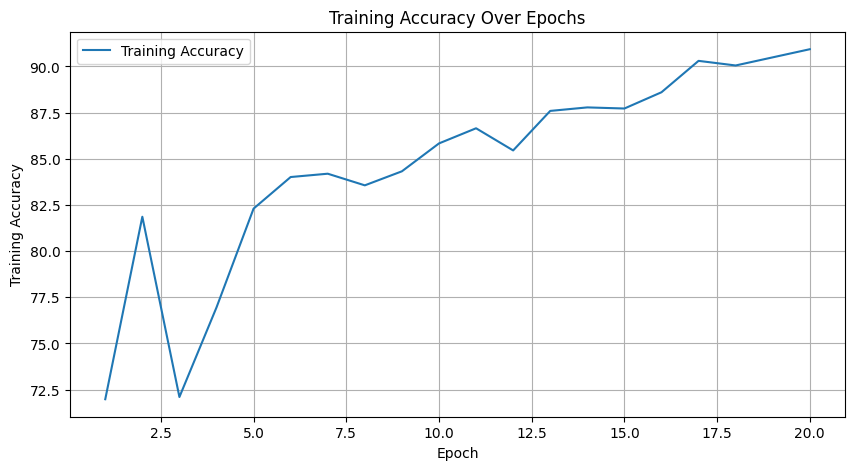

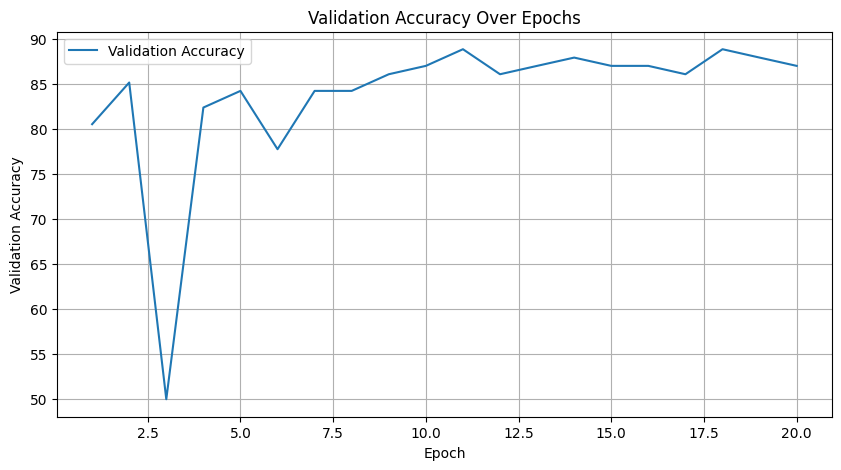

In [ ]:
import matplotlib.pyplot as plt
# Number of epochs
epochs = range(1, 21)

train_acc = [71.98, 81.86, 72.10, 76.95, 82.30, 84.01, 84.19, 83.56, 84.32, 85.83, 86.65, 85.45, 87.59, 87.78, 87.72, 88.60, 90.30, 90.05, 90.49, 90.93]

val_acc = [80.56, 85.19, 50.00, 82.41, 84.26, 77.78, 84.26, 84.26, 86.11, 87.04, 88.89, 86.11, 87.04, 87.96, 87.04, 87.04, 86.11, 88.89, 87.96, 87.04 ]


# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Plot the validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
model.eval()
test_correct = 0
test_total = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise use CPU

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 85.65%


In [ ]:
#since initial results look good, I am going to train for further epochs. I amd defining model again, so that i can save separately and analyse the output of the code cell

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Create a CNN model
class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 48 * 48, 128)  # Adjust input size based on image dimensions
        self.fc2 = nn.Linear(128, 2)  # Output layer with 1 neuron for binary classification (e.g., sigmoid activation)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the tensor before passing through fully connected layers
        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # The final output does not have an activation function for binary classification
        return x


# Initialize the model
model = CNNModel()

# Move the model to the GPU
model = model.to(device)


Using device: cuda


In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epoch_wise_training_accuracy = []
epoch_wise_val_accuracy = []
# Train and validate the model
num_epochs = 50
for epoch in range(num_epochs):
    print("started epoch: ", epoch)
    model.train()
    train_correct = 0  # To store the number of correct predictions
    train_total = 0
    batch_count=0
    for images, labels in train_loader:
        batch_count += 1
        #print("inside batch:", batch_count)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()


    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_correct = 0
    val_total = 0
    print("started val for this epoch")
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Accuracy: {train_accuracy:.2f}% - Validation Accuracy: {val_accuracy:.2f}%")
    epoch_wise_training_accuracy.append(train_accuracy)
    epoch_wise_val_accuracy.append(val_accuracy)


# You can now use this trained model for binary classification on new images.

started epoch:  0
started val for this epoch
Epoch [1/50] - Train Accuracy: 53.78% - Validation Accuracy: 68.52%
started epoch:  1
started val for this epoch
Epoch [2/50] - Train Accuracy: 70.40% - Validation Accuracy: 84.26%
started epoch:  2
started val for this epoch
Epoch [3/50] - Train Accuracy: 83.38% - Validation Accuracy: 85.19%
started epoch:  3
started val for this epoch
Epoch [4/50] - Train Accuracy: 83.50% - Validation Accuracy: 86.11%
started epoch:  4
started val for this epoch
Epoch [5/50] - Train Accuracy: 82.56% - Validation Accuracy: 86.11%
started epoch:  5
started val for this epoch
Epoch [6/50] - Train Accuracy: 85.08% - Validation Accuracy: 87.96%
started epoch:  6
started val for this epoch
Epoch [7/50] - Train Accuracy: 86.27% - Validation Accuracy: 87.96%
started epoch:  7
started val for this epoch
Epoch [8/50] - Train Accuracy: 87.91% - Validation Accuracy: 86.11%
started epoch:  8
started val for this epoch
Epoch [9/50] - Train Accuracy: 88.41% - Validation 

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/my_cam16_cnn_50ep.pth')

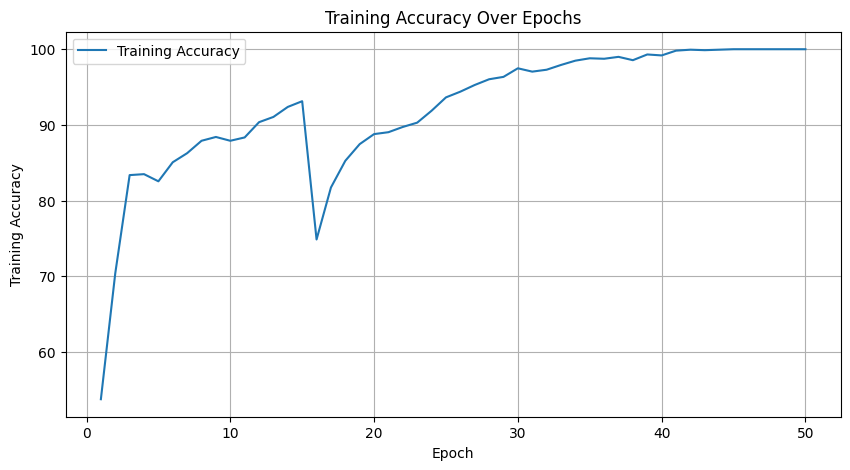

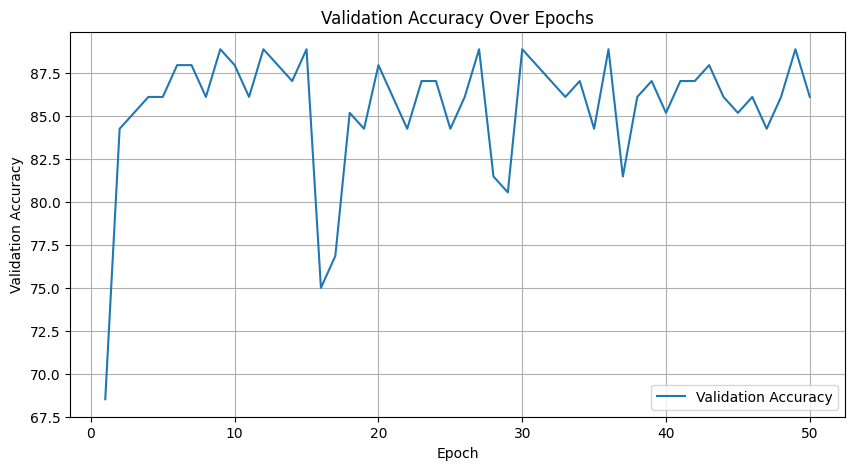

In [ ]:
import matplotlib.pyplot as plt
# Number of epochs
epochs = range(1, 51)

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, epoch_wise_training_accuracy, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Plot the validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, epoch_wise_val_accuracy, label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
#checking across classes
state_dict_a = torch.load('/content/drive/ My Drive/my_cam16_model.pth')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create model instances and load the state dictionaries
model = CNNModel().to(device)

# Load the state dictionaries into the models
model.load_state_dict(state_dict_a)

model.eval()

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=294912, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

print("doing val")
    # Perform validation after all epochs



model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    true_labels = []
    predicted_labels = []

    for inputs, labels in val_loader:
        #print("inside val batch")
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels for F1 score
        true_labels += labels.tolist()
        predicted_labels += predicted.tolist()

    # Calculate F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calculate overall accuracy
    correct_predictions = (np.array(true_labels) == np.array(predicted_labels)).sum()
    total_predictions = len(true_labels)
    overall_accuracy = 100 * correct_predictions / total_predictions

    # Calculate and store the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Print metrics for the final validation
    print('Final Validation Metrics:')
    print(f'Validation Accuracy: {overall_accuracy:.2f}%')
    print(f'F1 Score: {f1:.2f}')

    # Print the confusion matrix for the final validation
    print('Confusion Matrix (Final Validation):')
    print(confusion)

doing val
Final Validation Metrics:
Validation Accuracy: 87.04%
F1 Score: 0.87
Confusion Matrix (Final Validation):
[[50  4]
 [10 44]]


**Detailed Class-wise Report**

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=train_data.classes)


In [ ]:
print(report)

              precision    recall  f1-score   support

      normal       0.83      0.93      0.88        54
       tumor       0.92      0.81      0.86        54

    accuracy                           0.87       108
   macro avg       0.88      0.87      0.87       108
weighted avg       0.88      0.87      0.87       108



In [ ]:
import re
#Define a regular expression pattern to extract class-wise accuracy
pattern = r'(?P<class_name>[\w\s]+)\s+(?P<precision>\d+\.\d+)'

# Initialize a dictionary to store class-wise accuracy
class_wise_accuracy = {}

# Use regular expressions to extract class-wise accuracy
matches = re.finditer(pattern, report)
for match in matches:
    class_name = match.group('class_name')
    accuracy = float(match.group('precision'))
    class_wise_accuracy[class_name] = accuracy
    print(f'Class-wise Accuracy for {class_name}: {accuracy:.2f}')

Class-wise Accuracy for score   support

      normal      : 0.83
Class-wise Accuracy for      : 0.93
Class-wise Accuracy for      : 0.88
Class-wise Accuracy for         54
       tumor      : 0.92
Class-wise Accuracy for      : 0.81
Class-wise Accuracy for      : 0.86
Class-wise Accuracy for         54

    accuracy                          : 0.87
Class-wise Accuracy for        108
   macro avg      : 0.88
Class-wise Accuracy for      : 0.87
Class-wise Accuracy for      : 0.87
Class-wise Accuracy for        108
weighted avg      : 0.88
Class-wise Accuracy for      : 0.87
Class-wise Accuracy for      : 0.87
